In [ ]:
!pip install torch numpy matplotlib sacrebleu

     |████████████████████████████████| 71kB 5.7MB/s 


In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

In [ ]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

In [ ]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))  

In [ ]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

In [ ]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

In [ ]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

In [ ]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

In [ ]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

In [ ]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [ ]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

In [ ]:
def train_copy_task():
    """Train the simple copy task."""
    num_words = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))
 
    dev_perplexities = []
    
    if USE_CUDA:
        model.cuda()

    for epoch in range(10):
        
        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad(): 
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)
        
    return dev_perplexities

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 19.720032 Tokens per Sec: 11532.560066
Epoch Step: 100 Loss: 17.850552 Tokens per Sec: 14986.094622
Evaluation perplexity: 7.165516

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  5 8 7 5 8 7 5 8 7

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 8 8 8 8 8 8 8

Epoch 1
Epoch Step: 50 Loss: 15.429652 Tokens per Sec: 14914.005189
Epoch Step: 100 Loss: 11.758204 Tokens per Sec: 15256.591523
Evaluation perplexity: 3.761093

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 5 3 8 7 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 8 2 5 8 3 2

Epoch 2
Epoch Step: 50 Loss: 9.917423 Tokens per Sec: 14373.540757
Epoch Step: 100 Loss: 8.949948 Tokens per Sec: 15009.825701
Evaluation perplexity: 2.573576

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 3 5 7 8 10

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 

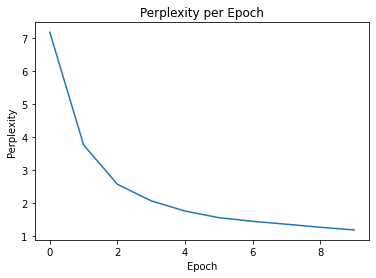

In [ ]:
# train the copy task
dev_perplexities = train_copy_task()

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

In [ ]:
!pip install git+git://github.com/pytorch/text spacy 
!python -m spacy download en
!python -m spacy download de

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-ksyoo0fh
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-ksyoo0fh
  Running command git submodule update --init --recursive -q
  Created wheel for torchtext: filename=torchtext-0.9.0a0+97e6d1d-cp36-cp36m-linux_x86_64.whl size=6980261 sha256=05c58814d3feb9529db73eec2cd1e00e3a2e25552f2c816b6b4ac54fc7faee4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-29hwzdze/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
Successfully built torchtext
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:05<00:00, 4.15MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/train.tags.de-en.de
.data/iwslt/de-en/train.tags.de-en.en


/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143115
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138329
         ,     105944
       und      41843
       die      40808
       das      33324
       sie      33034
       ich      31150
       ist      31037
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91615
       the      73343
       and      50276
        to      42799
         a      39572
        of      39496
         i      33521
        it      32920
      that      32640 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 und
06 die
07 das
08 sie
09 ich 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15765
Number of English words (types): 13002 



In [ ]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities

In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 116.590652 Tokens per Sec: 22602.028367
Epoch Step: 200 Loss: 45.832985 Tokens per Sec: 23930.318617
Epoch Step: 300 Loss: 50.010319 Tokens per Sec: 23764.277514
Epoch Step: 400 Loss: 84.559731 Tokens per Sec: 23311.010039
Epoch Step: 500 Loss: 84.707306 Tokens per Sec: 23622.070958
Epoch Step: 600 Loss: 52.742657 Tokens per Sec: 23830.411969
Epoch Step: 700 Loss: 84.035965 Tokens per Sec: 23597.579415
Epoch Step: 800 Loss: 60.506886 Tokens per Sec: 24105.930936
Epoch Step: 900 Loss: 50.634277 Tokens per Sec: 23488.550361
Epoch Step: 1000 Loss: 58.911953 Tokens per Sec: 23713.617462
Epoch Step: 1100 Loss: 18.165363 Tokens per Sec: 23629.999912
Epoch Step: 1200 Loss: 111.021767 Tokens per Sec: 23795.966721
Epoch Step: 1300 Loss: 72.016121 Tokens per Sec: 23716.446488
Epoch Step: 1400 Loss: 61.338413 Tokens per Sec: 23563.748447
Epoch Step: 1500 Loss: 33.586964 Tokens per Sec: 23492.431068
Epoch Step: 1600 Loss: 39.442581 Tokens per Sec: 23942.135215
Epoch Step: 170

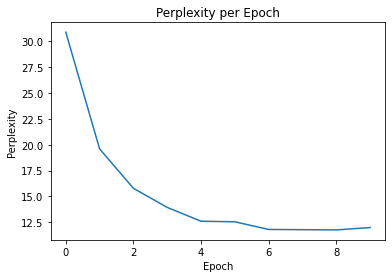

In [ ]:
plot_perplexity(dev_perplexities)

In [ ]:
import sacrebleu

In [ ]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

100.00000000000004


In [ ]:
len(valid_data)

690

In [ ]:
references = [" ".join(example.trg) for example in valid_data]
print(len(references))
print(references[0])

690
when i was 11 , i remember waking up one morning to the sound of joy in my house .


In [ ]:
references[-2]

"i 'm always the one taking the picture ."

In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
# we will still need to convert the indices to actual words!
hypotheses[0]

array([  70,   11,   24, 1460,  103,  217,    5,   11,   24,  562,   16,
          6,  690,   10,    6,  690,   10,    6,    0,    4])

In [ ]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

['when',
 'i',
 'was',
 '11',
 'years',
 'old',
 ',',
 'i',
 'was',
 'born',
 'in',
 'the',
 'morning',
 'of',
 'the',
 'morning',
 'of',
 'the',
 '<unk>',
 '.']

In [ ]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

690
when i was 11 years old , i was born in the morning of the morning of the <unk> .


In [ ]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

24.00860444696703


In [ ]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

src ['"', 'jetzt', 'kannst', 'du', 'auf', 'eine', 'richtige', 'schule', 'gehen', ',', '"', 'sagte', 'er', '.', '</s>']
ref ['"', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '"', 'he', 'said', '.', '</s>']
pred ['"', 'now', 'you', 'can', 'go', 'to', 'a', 'real', 'school', ',', '"', 'he', 'said', '.', '</s>']


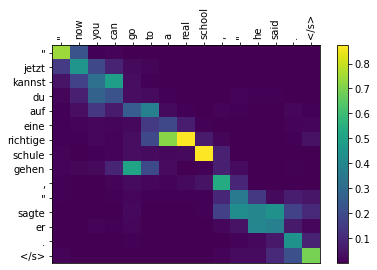

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)